# Descarga de imágenes

En este notebook se describen los pasos para descargar las imágenes del vuelo utilizadas en el modelo de detección, segmentación y clasificación.  Es necesario descargar imágenes tanto para el paso de entrenamiento del modelo, como para la posterior predicción dado un modelo ya entrenado. También se mostrarán unos ejemplos de cómo descargar imágenes de Sentinel-2.

## Ortoimágenes del vuelo aéreo

Las imágenes del vuelo se pueden consultar y descargar desde el [visualizador del IDE](https://visualizador.ide.uy/). En esta sección se darán ejemplos de consulta y descarga de imágenes de manera programática, utilizando dos paquetes des Python: owslib para interactuar con el servidor WMS, y el paquete de Python `ideuy`, desarrollado exclusivamente durante este taller y disponible en [GitHub](https://github.com/dymaxionlabs/ideuy-py).

### Estructura

* Cada ortoimagen (*urbana* y *nacional*) está particionada en *remesas*
* Cada remesa está subdividida en hojas.
* Para cada hoja se tiene una imagen en 3 formatos diferentes:
  - **GeoTiff RGBI 16-bit**: 4 bandas, RGB y NIR, con precisión de 16-bits
  - **GeoTiff RGBI 8-bit**: 4 bandas, RGB y NIR, con precisión de 8-bits
  - **JPG RGB 8-bit**: 3 bandas RGB, con precisión de 8-bits
  
Para el modelo de redes neuronales que utilizamos en este taller, alcanza con trabajar con formatos de precisión 8-bit. En particular, en los 3 proyectos trabajamos solamente con las bandas RGB en el caso de las imágenes del vuelo, con lo cual nos enfocaremos en *JPG RGB 8-bit*, pero si se quisiera incluir la banda del infrarrojo cercano, tendríamos que descargar *GeoTiff RGBI 8-bit* en cambio.

#### Remesas

![Remesas](img/remesas.jpg)

#### Grillas

![Grilla](img/grillas.jpg)

#### Grilla a nivel nacional

![Grilla a nivel nacional](img/nacional.jpg)

#### Grilla a nivel urbano

![Grilla a nivel urbano](img/urbana.jpg)

### WMS + owslib

Antes de pasar a la descarga de las imágenes para el modelo, nos gustaría mencionar una técnica que puede ser útil en determinadas situaciones.  Se puede utilizar el servicio WMS para descargar imagenes de tamaño fijo, dado una coordenada geográfica o un *bounding box* (rectángulo georreferenciado).

#### Ventajas
* Útil para obtener previsualizaciones o imágenes para otros formatos de documento (informes, reportes, etc.)
* Es una manera rápida y eficiente de obtener imágenes a partir de puntos o áreas de interés arbitrarias.
#### Desventajas
* Para áreas grandes no es muy eficiente
* Imágenes no georreferencias (JPG/PNG).

Para esto podemos utilizar el paquete de Python `owslib`, que permite interactuar con un servicio WMS programáticamente.

In [66]:
# Instalación del paquete
!pip install owslib

     |████████████████████████████████| 197 kB 2.8 MB/s eta 0:00:01


#### owslib: Ejemplo de uso

Supongamos que se tiene una planilla de puntos georeferenciados (con coordenadas geográficas) de paneles fotovoltáicos.  Se quiere armar un reporte con una imagen (urbana y nacional) para cada punto.

Hacer esto a mano implica recorrer cada punto desde un programa GIS y tomar una captura del visor.  Hacerlo automáticamente descargando alguno de los formatos disponibles de IDE también es costoso dado que los objetos son pequeños y descargar toda la hoja que contiene un panel es un desperdicio de tiempo y espacio.

In [67]:
from owslib.wms import WebMapService
import sys
import os
import csv
import random
from shapely.geometry import shape
from shapely.ops import unary_union
from skimage.exposure import is_low_contrast
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import cv2
import numpy as np
import fiona

La siguiente rutina itera por cada punto del GeoJSON, genera un buffer de 75 metros alrededor del punto, toma un recuadro y descarga una imagen de 1024x1024 para la capa urbana y nacional.  Las imágenes son descargadas en el directorio `data/wms/`

In [11]:
wms = WebMapService(
    'https://mapas.ide.uy/geoservicios/WMS/WMS_Uruguay_IDEuy_Ortofotos',
    version='1.3.0')
print("Capas:", list(wms.contents))

# Vamos a trabajar con ambas ortoimágenes (urbana y nacional)
layers = ['ortofoto_nacional', 'ortofoto_urbana']

# Directorio de salida para las imágenes
dst_dir = "data/wms/"

# Abrir shapefile de puntos
with fiona.open("data/wms/points.geojson") as src:
    points = [shape(f['geometry']) for f in src]

# Para cada punto, y para cada capa, descargar una imagen en el directorio
for i, point in enumerate(tqdm(points)):
    for layer in layers:
        # Hacemos un buffer de 75 metros, y tomamos su extensión como rectángulo
        bbox = point.buffer(20).bounds
        # Queremos guardar una imagen cuadrada de 1024px
        size = (1024, 1024)

        # Descarga la imagen
        response = wms.getmap(layers=[layer],
                              srs='EPSG:5382',
                              bbox=bbox,
                              size=size,
                              format='image/jpeg',
                              transparent=False)

        # Interpreta la imagen como JPG
        img = response.read()
        jpg_as_np = np.frombuffer(img, dtype=np.uint8)
        img_dec = cv2.imdecode(jpg_as_np, flags=1)

        # Si la imagen es válida (no es de "bajo contraste"), 
        # guarda la imagen en el dorectorio.
        if not is_low_contrast(img_dec):
            out_filename = f'{layer}_{i:0>4}.jpg'
            out_path = os.path.join(dst_dir, out_filename)
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            with open(out_path, 'wb') as dst:
                dst.write(img)

  0%|          | 0/5 [00:00<?, ?it/s]

Capas: ['ORTOFOTOS_2019', 'ortofoto_1966', 'ortofoto_infrarroja_nacional', 'ortofoto_infrarroja_urbana', 'ortofoto_nacional', 'ortofoto_urbana', 'ortofoto_ute']


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Podemos visualizar las imágenes usando matplotlib:

<Figure size 432x288 with 0 Axes>

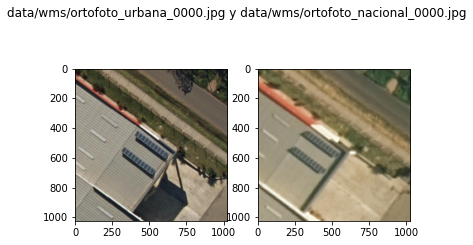

<Figure size 432x288 with 0 Axes>

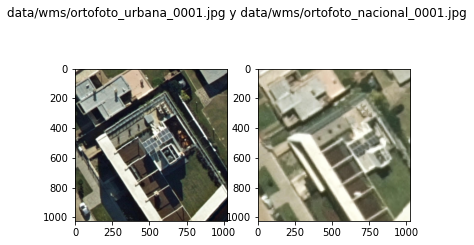

<Figure size 432x288 with 0 Axes>

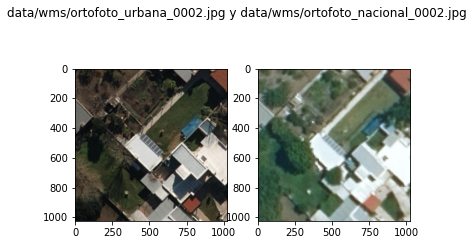

<Figure size 432x288 with 0 Axes>

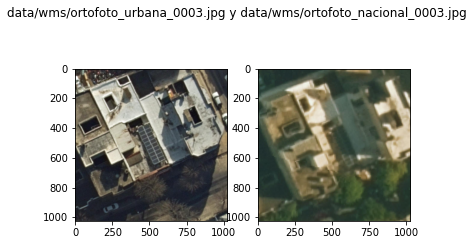

<Figure size 432x288 with 0 Axes>

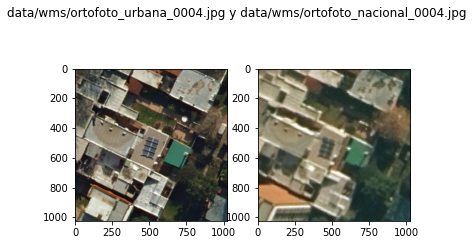

In [14]:
# Mostrar todas las imagenes urbanas y nacionales de a pares
urbanas = sorted(glob("data/wms/ortofoto_urbana_*.jpg"))
nacionales = sorted(glob("data/wms/ortofoto_nacional_*.jpg"))
for img_urb_p, img_nac_p in zip(urbanas, nacionales):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('{} y {}'.format(img_urb_p, img_nac_p))
    ax1.imshow(plt.imread(img_urb_p))
    ax2.imshow(plt.imread(img_nac_p))

### `ideuy-py`

`ideuy` es un paquete de Python que permite al usuario descargar programáticamente imágenes del vuelo aéreo tanto a nivel nacional como urbano, en cualquiera de los formatos disponibles en IDE.  Se puede utilizar tanto desde Python como desde línea de comando, a través de dos scripts de consola (`ideuy_filter` y `ideuy_download`).

El paquete es open-source (MIT) y está disponible en [GitHub](https://github.com/dymaxionlabs/ideuy-py).

#### Instalación

Para instalar `ideuy`, ejecutamos:

In [15]:
!pip install ideuy

Dos scripts de consola:

* `ideuy_filter`: Genera un GeoJSON de grilla (nacional o urbana) con las hojas de interés.
* `ideuy_download`: Descarga imágenes (en paralelo) de un formato a partir de un GeoJSON de grilla (generado por ideuy_filter).

In [16]:
!ideuy_filter -h

usage: ideuy_filter [-h] [--type {national,urban}] --output OUTPUT
                    [--grid-vector GRID_VECTOR] [--version] [-v] [-vv]
                    aoi_vector

Filter by AOI

positional arguments:
  aoi_vector            Path to AOI vector file

optional arguments:
  -h, --help            show this help message and exit
  --type {national,urban}, -t {national,urban}
                        Type of grid (default: national)
  --output OUTPUT, -o OUTPUT
                        Path to output GeoJSON vector file (default: None)
  --grid-vector GRID_VECTOR
                        Path to grid vector file. This overrides --type if
                        specified. (default: None)
  --version             show program's version number and exit
  -v, --verbose         set loglevel to INFO (default: None)
  -vv, --very-verbose   set loglevel to DEBUG (default: None)


In [18]:
!ideuy_download -h

usage: ideuy_download [-h] [-t {national,urban}]
                      [-p {rgbi_16bit,rgbi_8bit,rgb_8bit}] [-o OUTPUT_DIR]
                      [-j NUM_JOBS] [--version] [-v] [-vv]
                      grid_vector

Downloads image products from IDEuy

positional arguments:
  grid_vector           path to grid vector

optional arguments:
  -h, --help            show this help message and exit
  -t {national,urban}, --type {national,urban}
                        type of grid (default: national)
  -p {rgbi_16bit,rgbi_8bit,rgb_8bit}, --product-type {rgbi_16bit,rgbi_8bit,rgb_8bit}
                        product type (default: rgb_8bit)
  -o OUTPUT_DIR, --output-dir OUTPUT_DIR
                        output dir (default: .)
  -j NUM_JOBS, --num-jobs NUM_JOBS
                        number of simultaneous download threads (default: 1)
  --version             show program's version number and exit
  -v, --verbose         set loglevel to INFO (default: None)
  -vv, --very-verbose   set log

#### Ejemplo de uso

Supongamos que tenemos un Shapefile de polígonos, con áreas de interés.  Se quiere descargar imágenes RGB en formato JPG, a nivel urbano.

En general, los pasos a seguir son:
* (opcional) Reproyecto shapefile a CRS epsg:5381 (es un requerimiento de `ideuy_filter`)
* Filtro la grilla nacional con el Shapefile, usando `ideuy_filter`
* Descargo imágenes con `ideuy_download` y la grilla filtrada

**Ejemplo de áreas de interés**. Queremos descargar las hojas que contienen los polígonos de nuestro archivo vectorial.

![Ejemplo de áreas de interés](img/areas.jpg)

In [20]:
# Filtramos la grilla urbana. Esto genera un nuevo GeoJSON en data/ideuy/grilla_urbana_filtrada.geojson
!ideuy_filter --type urban \
              --output data/ideuy/grilla_urbana_filtrada.geojson \
              data/ideuy/areas.geojson

El comando anterior produce el archivo `grilla_urbana_filtrada.geojson`, que contiene las hojas de la ortoimagen urbana que intersecan con los polígonos de `areas.geojson`. Estas son las imágenes que debemos descargar.

In [21]:
!ls data/ideuy/

areas.geojson  grilla_urbana_filtrada.geojson


**Grilla urbana filtrada con áreas de interés.** Notar que el área que está fuera de la cobertura urbana no fue incluida. Para descargar imágenes que contenga ese polígono, habría que filtrar también a nivel nacional.

![Grilla urbana filtrada con áreas de interés](img/grilla_filtrada.jpg)

In [23]:
!ideuy_download --type urban \
                --product-type rgb_8bit \
                --output-dir data/ideuy/images/ \
                --num-jobs 4 \
                data/ideuy/grilla_urbana_filtrada.geojson

  0%|                                                     | 0/6 [00:00<?, ?it/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:   0%|              | 0.00/70.3M [00:00<?, ?B/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:   0%|              | 0.00/72.2M [00:00<?, ?B/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:   0%|              | 0.00/71.8M [00:00<?, ?B/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:   0%|              | 0.00/72.8M [00:00<?, ?B/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:   0%|   | 1.02k/70.3M [00:00<2:48:27, 6.95kB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:   0%|   | 1.02k/72.2M [00:00<2:33:07, 7.86kB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:   0%|   | 1.02k/71.8M [00:00<2:40:16, 7.46kB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:   0%|   | 1.02k/72.8M [00:00<2:44:57, 7.35kB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:   0%|    | 261k/70.3M [00:00<1:57:38, 9.92kB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:   0%|   | 90.1k/72.2M [00:00<1:47:27, 11.2kB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:   0%|   | 86.0k/71.8M [00:00<1:52:36, 10.6kB/s]
L26C3P6_RGB_8

L26C3P6_RGB_8_Remesa_07_SJM.jpg:  26%|█▎   | 18.1M/70.3M [00:06<00:23, 2.25MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  19%|▉    | 13.8M/72.2M [00:06<00:31, 1.83MB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  13%|▋    | 9.66M/72.8M [00:06<00:31, 2.02MB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  26%|█▎   | 18.5M/70.3M [00:06<00:21, 2.46MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  19%|▉    | 14.0M/72.2M [00:06<00:30, 1.89MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  11%|▌    | 7.65M/71.8M [00:06<00:59, 1.07MB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  27%|█▎   | 18.8M/70.3M [00:06<00:19, 2.63MB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  14%|▋    | 9.90M/72.8M [00:06<00:31, 1.99MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  11%|▋     | 7.76M/71.8M [00:06<01:04, 991kB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  20%|▉    | 14.2M/72.2M [00:06<00:32, 1.76MB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  27%|█▎   | 19.1M/70.3M [00:06<00:18, 2.81MB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  14%|▋    | 10.1M/72.8M [00:06<00:31, 2.02MB/s]


L26C6N3_RG

L26C6N2_RGB_8_Remesa_07_SJM.jpg:  34%|█▋   | 24.6M/72.8M [00:12<00:15, 3.19MB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  46%|██▎  | 32.0M/70.3M [00:12<00:13, 2.75MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  17%|▉     | 12.0M/71.8M [00:12<01:11, 831kB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  34%|█▋   | 25.0M/72.8M [00:12<00:14, 3.29MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  31%|█▌   | 22.2M/72.2M [00:12<00:48, 1.04MB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  46%|██▎  | 32.3M/70.3M [00:12<00:14, 2.61MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  17%|█     | 12.1M/71.8M [00:12<01:11, 837kB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  35%|█▋   | 25.3M/72.8M [00:12<00:14, 3.23MB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  46%|██▎  | 32.6M/70.3M [00:12<00:13, 2.76MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  31%|█▌   | 22.4M/72.2M [00:12<00:40, 1.22MB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  35%|█▊   | 25.7M/72.8M [00:12<00:14, 3.35MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  17%|█     | 12.2M/71.8M [00:12<01:13, 816kB/s]
L26C3P6_RGB

L26C6N2_RGB_8_Remesa_07_SJM.jpg:  46%|██▎  | 33.3M/72.8M [00:15<00:19, 2.03MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  21%|█    | 15.1M/71.8M [00:15<00:54, 1.04MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  35%|██    | 25.3M/72.2M [00:15<00:59, 787kB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  57%|██▊  | 39.9M/70.3M [00:15<00:12, 2.46MB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  46%|██▎  | 33.7M/72.8M [00:15<00:16, 2.43MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  35%|██    | 25.4M/72.2M [00:15<00:53, 882kB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  21%|█    | 15.3M/71.8M [00:15<00:50, 1.11MB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  57%|██▊  | 40.4M/70.3M [00:15<00:10, 2.77MB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  47%|██▎  | 34.0M/72.8M [00:15<00:15, 2.53MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  35%|██    | 25.5M/72.2M [00:16<00:50, 926kB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  58%|██▉  | 40.7M/70.3M [00:16<00:10, 2.87MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  22%|█    | 15.4M/71.8M [00:16<00:48, 1.16MB/s]



L26C6N2_RG

L26C3P6_RGB_8_Remesa_07_SJM.jpg:  67%|███▎ | 46.8M/70.3M [00:18<00:11, 2.07MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  25%|█▌    | 18.0M/71.8M [00:18<01:08, 782kB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  61%|███  | 44.2M/72.8M [00:18<00:07, 3.78MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  39%|██▎   | 27.9M/72.2M [00:18<00:51, 860kB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  67%|███▎ | 47.1M/70.3M [00:18<00:10, 2.28MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  25%|█▌    | 18.1M/71.8M [00:18<01:04, 826kB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  61%|███  | 44.6M/72.8M [00:18<00:07, 3.74MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  39%|██▎   | 28.0M/72.2M [00:18<00:46, 948kB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  62%|███  | 45.1M/72.8M [00:18<00:06, 4.03MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  25%|█▌    | 18.3M/71.8M [00:18<00:57, 927kB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  67%|███▎ | 47.4M/70.3M [00:18<00:09, 2.33MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  39%|█▉   | 28.2M/72.2M [00:19<00:41, 1.06MB/s]



L26C6N2

L26C6N2_RGB_8_Remesa_07_SJM.jpg:  74%|███▋ | 54.0M/72.8M [00:22<00:06, 2.84MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  43%|██▏  | 31.3M/72.2M [00:22<00:29, 1.40MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  29%|█▋    | 20.7M/71.8M [00:22<00:55, 922kB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  76%|███▊ | 53.5M/70.3M [00:22<00:07, 2.26MB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  75%|███▋ | 54.3M/72.8M [00:22<00:06, 2.93MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  44%|██▏  | 31.5M/72.2M [00:22<00:27, 1.50MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  29%|█▋    | 20.9M/71.8M [00:22<00:52, 976kB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  77%|███▊ | 53.8M/70.3M [00:22<00:06, 2.39MB/s]



L26C6N2_RGB_8_Remesa_07_SJM.jpg:  75%|███▊ | 54.7M/72.8M [00:22<00:05, 3.05MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  44%|██▏  | 31.7M/72.2M [00:22<00:27, 1.49MB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  77%|███▊ | 54.1M/70.3M [00:22<00:06, 2.44MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  29%|█▊    | 21.0M/71.8M [00:22<00:51, 995kB/s]



L26C6N2_RG

L26C3P6_RGB_8_Remesa_07_SJM.jpg:  92%|████▌| 64.5M/70.3M [00:28<00:02, 2.22MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  54%|██▋  | 39.0M/72.2M [00:28<00:22, 1.49MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  36%|██▏   | 25.6M/71.8M [00:28<00:56, 821kB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  92%|████▌| 64.9M/70.3M [00:28<00:02, 2.47MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  54%|██▋  | 39.3M/72.2M [00:28<00:19, 1.67MB/s]



L26D1O4_RGB_8_Remesa_07_SJM.jpg:   0%|              | 0.00/43.6M [00:00<?, ?B/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  36%|██▏   | 25.8M/71.8M [00:28<00:48, 953kB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  93%|████▋| 65.2M/70.3M [00:28<00:01, 2.65MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  55%|██▋  | 39.5M/72.2M [00:28<00:18, 1.76MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  36%|██▏   | 25.9M/71.8M [00:28<00:49, 922kB/s]
L26C3P6_RGB_8_Remesa_07_SJM.jpg:  93%|████▋| 65.5M/70.3M [00:28<00:01, 2.55MB/s]



L26D1O4_RGB_8_Remesa_07_SJM.jpg:   0%|   | 1.02k/43.6M [00:00<2:27:01, 4.94kB/s]

L26C3P9_RGB_

L26D1O4_RGB_8_Remesa_07_SJM.jpg:  50%|██▌  | 22.0M/43.6M [00:06<00:04, 5.14MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  42%|██▌   | 30.4M/71.8M [00:34<00:46, 889kB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:   3%|▏     | 1.91M/70.6M [00:02<04:24, 260kB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  63%|███▊  | 45.4M/72.2M [00:34<00:31, 854kB/s]



L26D1O4_RGB_8_Remesa_07_SJM.jpg:  52%|██▌  | 22.5M/43.6M [00:06<00:04, 5.25MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  43%|██▌   | 30.5M/71.8M [00:34<00:47, 874kB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  63%|███▊  | 45.5M/72.2M [00:34<00:29, 894kB/s]



L26D1O4_RGB_8_Remesa_07_SJM.jpg:  53%|██▋  | 23.1M/43.6M [00:06<00:04, 4.86MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:   3%|▏     | 2.08M/70.6M [00:02<03:24, 335kB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  43%|██▌   | 30.6M/71.8M [00:34<00:44, 928kB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  63%|███▊  | 45.6M/72.2M [00:34<00:29, 915kB/s]



L26D1O4_RGB_8_Remesa_07_SJM.jpg:  54%|██▋  | 23.6M/43.6M [00:06<00:04, 4.89MB/s]
L26D1O7_RG

L26D1O7_RGB_8_Remesa_07_SJM.jpg:  13%|▋    | 9.18M/70.6M [00:08<00:40, 1.53MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  52%|██▌  | 37.3M/71.8M [00:40<00:23, 1.48MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  72%|███▌ | 52.3M/72.2M [00:40<00:13, 1.51MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  13%|▋    | 9.36M/70.6M [00:08<00:38, 1.60MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  52%|██▌  | 37.5M/71.8M [00:40<00:22, 1.53MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  73%|███▋ | 52.4M/72.2M [00:40<00:12, 1.58MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  14%|▋    | 9.55M/70.6M [00:08<00:38, 1.60MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  52%|██▌  | 37.6M/71.8M [00:41<00:22, 1.49MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  73%|███▋ | 52.6M/72.2M [00:41<00:12, 1.60MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  14%|▋    | 9.75M/70.6M [00:08<00:36, 1.68MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  53%|██▋  | 37.8M/71.8M [00:41<00:20, 1.63MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  73%|███▋ | 52.8M/72.2M [00:41<00:12, 1.56MB/s]
L26D1O7_RGB_8_Re

L26C6N3_RGB_8_Remesa_07_SJM.jpg:  62%|███  | 44.4M/71.8M [00:44<00:10, 2.64MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  81%|████ | 58.7M/72.2M [00:44<00:05, 2.32MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  23%|█▏   | 16.6M/70.6M [00:12<00:22, 2.40MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  62%|███  | 44.7M/71.8M [00:44<00:10, 2.62MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  82%|████ | 58.9M/72.2M [00:44<00:05, 2.31MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  24%|█▏   | 16.8M/70.6M [00:12<00:22, 2.40MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  63%|███▏ | 44.9M/71.8M [00:44<00:10, 2.61MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  82%|████ | 59.2M/72.2M [00:44<00:05, 2.48MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  24%|█▏   | 17.1M/70.6M [00:12<00:20, 2.60MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  63%|███▏ | 45.2M/71.8M [00:44<00:10, 2.54MB/s]

L26C3P9_RGB_8_Remesa_07_SJM.jpg:  82%|████ | 59.5M/72.2M [00:45<00:05, 2.49MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  25%|█▏   | 17.4M/70.6M [00:12<00:20, 2.60MB/s]


L26C6N3_RGB_8_Re

 67%|██████████████████████████████               | 4/6 [00:53<00:31, 15.83s/it]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  85%|████▎| 61.3M/71.8M [00:52<00:02, 4.60MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  45%|██▏  | 31.8M/70.6M [00:20<00:16, 2.35MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  86%|████▎| 61.8M/71.8M [00:52<00:02, 4.52MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  45%|██▎  | 32.0M/70.6M [00:20<00:17, 2.21MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  87%|████▎| 62.3M/71.8M [00:52<00:02, 4.65MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  46%|██▎  | 32.3M/70.6M [00:20<00:15, 2.40MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  88%|████▍| 62.8M/71.8M [00:53<00:04, 2.08MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  46%|██▊   | 32.6M/70.6M [00:20<00:38, 986kB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  88%|████▍| 63.2M/71.8M [00:53<00:03, 2.18MB/s]
L26D1O7_RGB_8_Remesa_07_SJM.jpg:  46%|██▎  | 32.8M/70.6M [00:21<00:34, 1.09MB/s]


L26C6N3_RGB_8_Remesa_07_SJM.jpg:  88%|████▍| 63.5M/71.8M [00:53<00:03, 2.19MB/s]
L26D1O7_RGB_8_Re

Este comando descarga en paralelo (máximo 4 hilos) las imágenes en formato RGB 8bit (jpg) en el directorio `data/ideuy/images/`, segun las hojas de `grilla_urbana_filtrada.geojson`.

In [24]:
!ls data/ideuy/images

L26C3P6_RGB_8_Remesa_07_SJM.jgw  L26C6N3_RGB_8_Remesa_07_SJM.jgw
L26C3P6_RGB_8_Remesa_07_SJM.jpg  L26C6N3_RGB_8_Remesa_07_SJM.jpg
L26C3P9_RGB_8_Remesa_07_SJM.jgw  L26D1O4_RGB_8_Remesa_07_SJM.jgw
L26C3P9_RGB_8_Remesa_07_SJM.jpg  L26D1O4_RGB_8_Remesa_07_SJM.jpg
L26C6N2_RGB_8_Remesa_07_SJM.jgw  L26D1O7_RGB_8_Remesa_07_SJM.jgw
L26C6N2_RGB_8_Remesa_07_SJM.jpg  L26D1O7_RGB_8_Remesa_07_SJM.jpg


**Imágenes descargadas**: Notar que para cada archivo `.jpg` hay un archivo de igual nombre pero con extensión `.jgw`. Estos archivos se llaman *World files* y iempre van en conjunto con los jpgs. Son archivos que incluyen información de georreferenciación de las imágenes (técnicamente, son los elementos de la [transformación afín](https://en.wikipedia.org/wiki/World_file)).

![Imágenes descargadas](img/imagenes_descargadas.jpg)

**Un comentario**: Si cargan las imágenes del formato JPG en QGIS, van a notar que QGIS no va a saber ubicar bien las imágenes porque no sabe que CRS (Sistema de Referencia de Coordenadas) tienen (el world file sólo tiene información afín, pero no se sabe que CRS es). Se debe explicitar manualmente seteando el CRS a epsg:5382 en las propiedades de cada capa.

## Imágenes satelitales: Sentinel-2

Para algunos proyectos se trabajó también con imágenes del sensor Sentinel-2 de la ESA. Las imágenes multiespectrales de Sentinel-2 tiene 13 bandas:

* 4 bandas de 10m: RGB y NIR
* 6 bandas de 20m: SWIR, red edge, etc.
* 3 bandas de 60m

La revisita de la constelación es de aproximadamente 5 días, por lo cual resultan muy útiles a la hora de analizar una serie de tiempo, o tener un monitoreo a gran escala de determinadas áreas de interés.
Para más información puede consultar la [Guía de usuario](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi).

| Sentinel-2 Bands              | Central Wavelength (µm) | Resolution (m) |
|-------------------------------|-------------------------|----------------|
| Band 1 - Coastal aerosol      |                   0.443 |             60 |
| Band 2 - Blue                 |                    0.49 |             10 |
| Band 3 - Green                |                    0.56 |             10 |
| Band 4 - Red                  |                   0.665 |             10 |
| Band 5 - Vegetation Red Edge  |                   0.705 |             20 |
| Band 6 - Vegetation Red Edge  |                    0.74 |             20 |
| Band 7 - Vegetation Red Edge  |                   0.783 |             20 |
| Band 8 - NIR                  |                   0.842 |             10 |
| Band 8A - Vegetation Red Edge |                   0.865 |             20 |
| Band 9 - Water vapour         |                   0.945 |             60 |
| Band 10 - SWIR - Cirrus       |                   1.375 |             60 |
| Band 11 - SWIR                |                    1.61 |             20 |
| Band 12 - SWIR                |                    2.19 |             20 |

![Bandas](img/s2_bands.jpg)

Generalmente se trabaja con dos productos, con corrección radiométrica y ortorectificación aplicada.

1. **L1C**: Top-of-atmosphere (ToA) reflectance
2. **L2A**: Bottom-of-atmosphere (BoA) reflectance (también llamada Top-of-canopy)

L2A tiene **corrección atmosférica**, y es necesario para analizar índices de vegetación como NDVI o NDWI. La mayoría de las veces es preferible trabajar en ese nivel.  Uno puede generar un producto de nivel L2A a partir de L1C utilizando el software [Sen2Cor](https://step.esa.int/main/third-party-plugins-2/sen2cor/).

![Comparación entre niveles L1C y L2A](img/l1c_vs_l2a.jpg)

Las imágenes son también de dominio público y se pueden descargar de diferentes fuentes. En este caso vamos a descargar directamente de [Copernicus Open Access Hub](https://scihub.copernicus.eu/), utilizando un paquete llamado [sentinelsat](https://sentinelsat.readthedocs.io/en/stable/).

In [30]:
# Instalamos sentinelsat, y folium para visualizar los resultados
!pip install sentinelsat folium

     |████████████████████████████████| 93 kB 1.6 MB/s eta 0:00:01


Es necesario primero [registrarse en Copernicus](https://scihub.copernicus.eu/dhus/#/self-registration), dado que necesitamos ingresar usuario y contraseña para consultar y descargar productos.

In [18]:
from getpass import getpass
import os

username = os.getenv('DHUS_USER')
password = os.getenv('DHUS_PASSWORD')

if not (username and password):
    username = input('DHUS username: ')
    password = getpass('DHUS password: ')

Inicializamos el API para consultar y descargar productos de Sentinel.

In [19]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

In [20]:
api = SentinelAPI(username, password)

Leemos un archivo GeoJSON ubicado en `data/sen2/area.geojson` y leemos el polígono. Se asume que el GeoJSON tiene un único feature, con una geometría asociada.

**Captura del area de interés**
![](img/sen2_area.jpg)

In [35]:
area_geo = read_geojson('data/sen2/area.geojson')
footprint = geojson_to_wkt(area_geo)

In [25]:
footprint

'POLYGON((-56.4662 -34.9739,-56.4662 -34.6052,-55.7528 -34.6052,-55.7528 -34.9739,-56.4662 -34.9739))'

Hacemos una primer consulta. Buscamos imágenes de los primeros días de octubre del 2019, por lo que queremos filtrar por el campo `date`.

In [31]:
products = api.query(footprint,
                     date=('20191001', '20191010'),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 10),
                     producttype='S2MSI2A')

In [32]:
len(products)

2

In [33]:
api.to_dataframe(products)

,title,link,link_alternative,link_icon,summary,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,...,platformserialidentifier,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid
e77d7d46-fcc8-4e8a-a29d-f3f1b096a54e,S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-10-08T13:42:11.024Z, Instrument: MS...",2019-10-08 13:42:11.024,2019-10-08 13:42:11.024,2019-10-08 20:38:14.298,22429,124,...,Sentinel-2A,02.13,Level-2A,S2MSI2A,Sentinel-2,899.65 MB,S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_2...,S2A_OPER_MSI_L1C_TL_SGS__20191008T152051_A0224...,S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_2...,e77d7d46-fcc8-4e8a-a29d-f3f1b096a54e
31206aba-d6ba-465d-b908-2410c69ec3c4,S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-10-08T13:42:11.024Z, Instrument: MS...",2019-10-08 13:42:11.024,2019-10-08 13:42:11.024,2019-10-08 20:38:01.868,22429,124,...,Sentinel-2A,02.13,Level-2A,S2MSI2A,Sentinel-2,814.11 MB,S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_2...,S2A_OPER_MSI_L1C_TL_SGS__20191008T152051_A0224...,S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_2...,31206aba-d6ba-465d-b908-2410c69ec3c4


Vemos que esto arroja 2 resultados. Cada producto pueden ser diferentes *tiles* o *teselas* de una misma escena o captura. En este caso, son dos teselas de una misma escena, dado que ambos tienen misma fecha y hora de captura.

Ya que estamos, antes de seguir, vamos a visualizar los footprints de cada escena, para entender como son las imagenes antes de bajarlas. Podriamos descargar el geojson y visualizarlo en QGIS, pero tambien podemos usar `folium` para tener un mapa en el notebook.

In [40]:
import folium
import json

products_geo = api.to_geojson(products)

m = folium.Map(min_zoom=7, max_zoom=18)

area_layer = folium.GeoJson(area_geo, name='area', style_function=lambda x: {'color': '#ff0000', 'fillColor': '#ff0000'}).add_to(m)
sen2_layer = folium.GeoJson(products_geo, name='sen2').add_to(m)

# Tomar los bounds de la capa sen2 layer para centrar el mapa
m.fit_bounds(sen2_layer.get_bounds())

m

Ahora descargamos las dos teselas:

In [42]:
dirname = 'data/sen2/images/'
os.makedirs(dirname, exist_ok=True)
api.download_all(products, directory_path=dirname)

Downloading:   0%|          | 0.00/943M [00:00<?, ?B/s]
Downloading:   1%|          | 7.34M/943M [00:01<03:34, 4.35MB/s]
Downloading:   1%|          | 9.44M/943M [00:01<02:51, 5.44MB/s]
Downloading:   1%|          | 10.5M/943M [00:01<02:51, 5.43MB/s]
Downloading:   1%|          | 11.5M/943M [00:01<03:02, 5.12MB/s]
Downloading:   1%|          | 6.29M/854M [00:01<05:12, 2.71MB/s]
Downloading:   1%|▏         | 12.6M/943M [00:01<03:17, 4.71MB/s]
Downloading:   2%|▏         | 15.7M/943M [00:02<02:28, 6.23MB/s]
Downloading:   2%|▏         | 17.8M/943M [00:02<02:12, 6.98MB/s]
Downloading:   2%|▏         | 19.9M/943M [00:02<02:02, 7.54MB/s]
Downloading:   3%|▎         | 24.1M/943M [00:02<01:30, 10.1MB/s]
Downloading:   3%|▎         | 26.2M/943M [00:02<01:19, 11.5MB/s]
Downloading:   3%|▎         | 28.3M/943M [00:03<01:19, 11.5MB/s]
Downloading:   3%|▎         | 22.0M/854M [00:02<01:40, 8.26MB/s]
Downloading:   3%|▎         | 30.4M/943M [00:03<01:25, 10.7MB/s]
Downloading:   3%|▎         | 32.5

Downloading:  47%|████▋     | 440M/943M [00:46<02:02, 4.10MB/s]
Downloading:  47%|████▋     | 442M/943M [00:46<01:32, 5.40MB/s]
Downloading:  47%|████▋     | 446M/943M [00:46<01:25, 5.82MB/s]
Downloading:  55%|█████▍    | 467M/854M [00:46<00:54, 7.06MB/s]
Downloading:  47%|████▋     | 447M/943M [00:47<02:09, 3.83MB/s]
Downloading:  55%|█████▍    | 469M/854M [00:47<01:12, 5.28MB/s]
Downloading:  47%|████▋     | 448M/943M [00:47<02:08, 3.86MB/s]
Downloading:  48%|████▊     | 451M/943M [00:48<01:23, 5.90MB/s]
Downloading:  48%|████▊     | 452M/943M [00:48<01:19, 6.18MB/s]
Downloading:  48%|████▊     | 453M/943M [00:48<01:26, 5.65MB/s]
Downloading:  56%|█████▌    | 477M/854M [00:48<00:52, 7.20MB/s]
Downloading:  48%|████▊     | 454M/943M [00:48<01:22, 5.93MB/s]
Downloading:  48%|████▊     | 456M/943M [00:48<01:27, 5.54MB/s]
Downloading:  49%|████▊     | 459M/943M [00:49<01:06, 7.33MB/s]
Downloading:  56%|█████▋    | 482M/854M [00:48<00:50, 7.29MB/s]
Downloading:  49%|████▉     | 461M/943M 

({'31206aba-d6ba-465d-b908-2410c69ec3c4': {'id': '31206aba-d6ba-465d-b908-2410c69ec3c4',
   'title': 'S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_20191008T160116',
   'size': 853718402,
   'md5': 'F168C9D6746508C93CCB52E657B953BC',
   'date': datetime.datetime(2019, 10, 8, 13, 42, 11, 24000),
   'footprint': 'POLYGON((-54.71847026776346 -34.3675475076434,-54.72342993451692 -34.38560842583506,-54.76343332719095 -34.53272506832837,-54.80310346715844 -34.68004509784106,-54.84320300238729 -34.827308633838086,-54.88328458353636 -34.97465625080147,-54.92347672916977 -35.12208295951896,-54.963748768843054 -35.26958713077182,-54.975711246192446 -35.31323209988858,-55.89976704802919 -35.32625771119615,-55.91285848743989 -34.336296079232476,-54.71979190066199 -34.31988843474364,-54.71847026776346 -34.3675475076434))',
   'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('31206aba-d6ba-465d-b908-2410c69ec3c4')/$value",
   'Online': True,
   'Creation Date': datetime.datetime(2019, 10

In [43]:
!ls data/sen2/images

S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.zip
S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_20191008T160116.zip


Cada producto viene en un Zip, que hay que extraer:

In [47]:
!for f in data/sen2/images/*.zip; do unzip $f -d data/sen2/images/; done

Archive:  data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.zip
   creating: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/INSPIRE.xml  
   creating: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/rep_info/
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/rep_info/S2_PDI_Level-2A_Tile_Metadata.xsd  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/rep_info/S2_PDI_Level-2A_Datastrip_Metadata.xsd  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/rep_info/S2_User_Product_Level-2A_Metadata.xsd  
   creating: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/HTML/
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N021

 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/L2A_T21HWB_A022429_20191008T134213/QI_DATA/RADIOMETRIC_QUALITY.xml  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/L2A_T21HWB_A022429_20191008T134213/QI_DATA/MSK_DETFOO_B02.gml  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/L2A_T21HWB_A022429_20191008T134213/QI_DATA/MSK_TECQUA_B11.gml  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/L2A_T21HWB_A022429_20191008T134213/QI_DATA/GEOMETRIC_QUALITY.xml  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/L2A_T21HWB_A022429_20191008T134213/QI_DATA/MSK_SATURA_B01.gml  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/L2A_T21HWB_A022429_20191008T134213/QI_DATA/MSK_D

 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/L2A_T21HWB_A022429_20191008T134213/IMG_DATA/R10m/T21HWB_20191008T134211_B02_10m.jp2  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/L2A_T21HWB_A022429_20191008T134213/IMG_DATA/R10m/T21HWB_20191008T134211_B04_10m.jp2  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/L2A_T21HWB_A022429_20191008T134213/IMG_DATA/R10m/T21HWB_20191008T134211_TCI_10m.jp2  
   creating: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/AUX_DATA/
   creating: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/DATASTRIP/
   creating: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/DATASTRIP/DS_SGS__20191008T160116_S20191008T134213/
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T

 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_20191008T160116.SAFE/GRANULE/L2A_T21HXB_A022429_20191008T134213/IMG_DATA/R60m/T21HXB_20191008T134211_B03_60m.jp2  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_20191008T160116.SAFE/GRANULE/L2A_T21HXB_A022429_20191008T134213/IMG_DATA/R60m/T21HXB_20191008T134211_B06_60m.jp2  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_20191008T160116.SAFE/GRANULE/L2A_T21HXB_A022429_20191008T134213/IMG_DATA/R60m/T21HXB_20191008T134211_TCI_60m.jp2  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_20191008T160116.SAFE/GRANULE/L2A_T21HXB_A022429_20191008T134213/IMG_DATA/R60m/T21HXB_20191008T134211_B8A_60m.jp2  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_20191008T160116.SAFE/GRANULE/L2A_T21HXB_A022429_20191008T134213/IMG_DATA/R60m/T21HXB_20191008T134211_B09_60m.jp2  
 extracting: data/sen2/images/S2A_MSIL2A_20191008T

In [52]:
!tree -d data/sen2/images/*.SAFE

data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE
├── AUX_DATA
├── DATASTRIP
│   └── DS_SGS__20191008T160116_S20191008T134213
│       └── QI_DATA
├── GRANULE
│   └── L2A_T21HWB_A022429_20191008T134213
│       ├── AUX_DATA
│       ├── IMG_DATA
│       │   ├── R10m
│       │   ├── R20m
│       │   └── R60m
│       └── QI_DATA
├── HTML
└── rep_info
data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HXB_20191008T160116.SAFE
├── AUX_DATA
├── DATASTRIP
│   └── DS_SGS__20191008T160116_S20191008T134213
│       └── QI_DATA
├── GRANULE
│   └── L2A_T21HXB_A022429_20191008T134213
│       ├── AUX_DATA
│       ├── IMG_DATA
│       │   ├── R10m
│       │   ├── R20m
│       │   └── R60m
│       └── QI_DATA
├── HTML
└── rep_info

28 directories


Para cada escena, las imágenes suelen encontrarse dentro del directorio `GRANULE/L2A_*/IMG_DATA` donde `*` suele ser un id de la escena. Para el caso de los productos de nivel L2A, dentro de `IMG_DATA` hay 3 directorios:

* R10m: Imágenes de resolucion 10m
* R20m: Imágenes de resolución 20m
* R60m: Imágenes de resolución 60m

Generalmente cada banda viene separada en un archivo distinto:

In [60]:
!tree data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/*/IMG_DATA

data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/L2A_T21HWB_A022429_20191008T134213/IMG_DATA
├── R10m
│   ├── T21HWB_20191008T134211_AOT_10m.jp2
│   ├── T21HWB_20191008T134211_B02_10m.jp2
│   ├── T21HWB_20191008T134211_B03_10m.jp2
│   ├── T21HWB_20191008T134211_B04_10m.jp2
│   ├── T21HWB_20191008T134211_B08_10m.jp2
│   ├── T21HWB_20191008T134211_TCI_10m.jp2
│   └── T21HWB_20191008T134211_WVP_10m.jp2
├── R20m
│   ├── T21HWB_20191008T134211_AOT_20m.jp2
│   ├── T21HWB_20191008T134211_B02_20m.jp2
│   ├── T21HWB_20191008T134211_B03_20m.jp2
│   ├── T21HWB_20191008T134211_B04_20m.jp2
│   ├── T21HWB_20191008T134211_B05_20m.jp2
│   ├── T21HWB_20191008T134211_B06_20m.jp2
│   ├── T21HWB_20191008T134211_B07_20m.jp2
│   ├── T21HWB_20191008T134211_B11_20m.jp2
│   ├── T21HWB_20191008T134211_B12_20m.jp2
│   ├── T21HWB_20191008T134211_B8A_20m.jp2
│   ├── T21HWB_20191008T134211_SCL_20m.jp2
│   ├── T21HWB_20191008T134211_TCI_20m.jp2
│   └── T21HWB_20191008T134211

Si queremos solamente trabajar con RGB, podemos utilizar directamente el producto TCI (True Color Image), que corresponde a una imagen RGB de 8-bit, con los valores escalados correctamente para visualización.

> The TCI is an RGB image built from the B02 (Blue), B03 (Green), and B04 (Red) Bands. The reflectances are coded between 1 and 255, 0 being reserved for 'No Data'. The saturation level of 255 digital counts correspond to a level of 3558 for L1C products or 2000 for L2A products (0.3558 and 0.2 in reflectance value respectively.

Es decir, es la combinación de las bandas 4-3-2 (RGB), reescalado a uint8 (8-bits de precisión) tomando como valor máximo el 2000.

In [86]:
from glob import glob
from skimage.exposure import rescale_intensity
import rasterio

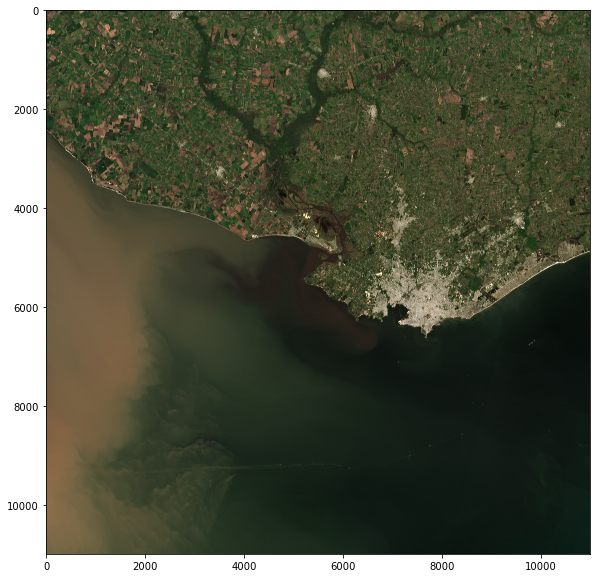

In [73]:
tci_path = list(glob("data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/*/IMG_DATA/R10m/*_TCI_*.jp2"))[0]

with rasterio.open(tci_path) as src:
    img = np.dstack(src.read())
    plt.figure(figsize=(10,10))
    plt.imshow(img)

Si deseamos trabajar también con NIR, nos conviene usar las bandas por separado. Deberíamos reescalarlas entre 0 y 2000, tal como se hace en el caso de TCI: 

In [113]:
base_path = "data/sen2/images/S2A_MSIL2A_20191008T134211_N0213_R124_T21HWB_20191008T160116.SAFE/GRANULE/*/IMG_DATA/R10m/"
r_path = glob(f"{base_path}/*_B04_*.jp2")[0]
g_path = glob(f"{base_path}/*_B03_*.jp2")[0]
b_path = glob(f"{base_path}/*_B02_*.jp2")[0]
nir_path = glob(f"{base_path}/*_B08_*.jp2")[0]

def read_image(path):
    with rasterio.open(path) as src:
        return src.read(1)

rgbi = np.dstack([read_image(p) for p in [r_path, g_path, b_path, nir_path]])

In [114]:
rgbi.shape, rgbi.dtype, rgbi.min(), rgbi.max(), rgbi.mean()

((10980, 10980, 4), dtype('uint16'), 1, 17664, 739.986995825329)

In [115]:
# Clip image
rgbi = rgbi[5000:7000,6000:10000,:]

In [116]:
rgbi = rescale_intensity(rgbi, in_range=(0, 2000), out_range='uint8')

In [117]:
rgbi.shape, rgbi.dtype, rgbi.min(), rgbi.max(), rgbi.mean()

((2000, 4000, 4), dtype('uint8'), 0, 255, 92.0096501875)

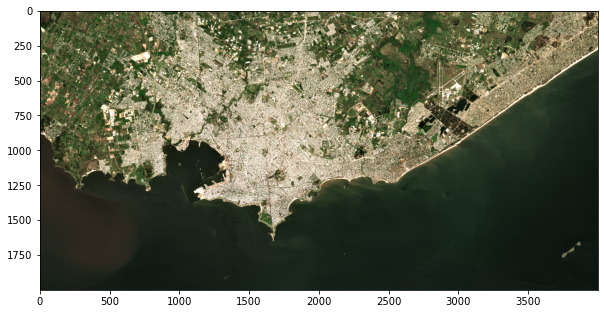

In [118]:
# RGB
img = rgbi[:,:,:3]
plt.figure(figsize=(10, 10))
plt.imshow(img)

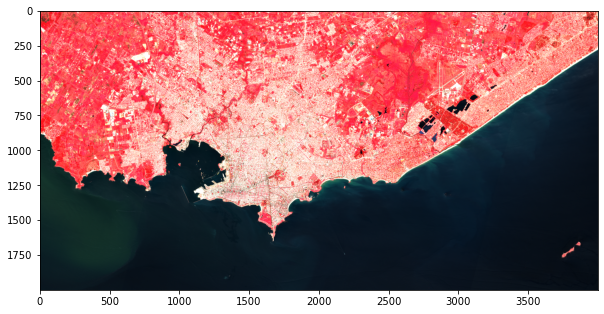

In [120]:
# False color (NIR, R, G)
img = np.dstack([rgbi[:,:,3], rgbi[:,:,0], rgbi[:,:,1]])
plt.figure(figsize=(10, 10))
plt.imshow(img)